In [262]:
import requests
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import importlib
import osmnx as ox
import networkx as nx
# import networkx.algorithms.traversal.breadth_first_search as bfs
from math import ceil

import LTA_API_key
import helper_functions.routing.publicTransit

importlib.reload(LTA_API_key)
importlib.reload(helper_functions.routing.publicTransit)

import LTA_API_key as apiKeys
import helper_functions.routing.publicTransit as publicTransit
from scipy.spatial.distance import cdist
from datetime import datetime

# OneMapAPI

### Get token

In [212]:
headers = publicTransit.generate_OneMap_token()

### Search

In [213]:
location = '59159 (BUS STOP)'

url = f"https://www.onemap.gov.sg/api/common/elastic/search?searchVal={location}&returnGeom=Y&getAddrDetails=Y"
    
response = publicTransit.get_OneMap_response(url,headers=headers)
response_first_result = response['results'] # get first item in the list
response_first_result

[{'SEARCHVAL': '59159 (BUS STOP)',
  'BLK_NO': '',
  'ROAD_NAME': 'YISHUN AVE 5',
  'BUILDING': '59159 (BUS STOP)',
  'ADDRESS': '59159 (BUS STOP)',
  'POSTAL': 'NIL',
  'X': '28150.4695976423',
  'Y': '45808.9831599183',
  'LATITUDE': '1.4305546622766',
  'LONGITUDE': '103.83467068843'}]

### Get data layers

In [214]:
url = "https://www.onemap.gov.sg/api/public/themesvc/getAllThemesInfo?moreInfo=Y"
response = publicTransit.get_OneMap_response(url,headers=headers)
response

{'Theme_Names': [{'THEMENAME': 'After Death Facilities',
   'QUERYNAME': 'afterdeathfacilities',
   'ICON': 'coffina20.jpg',
   'EXPIRY_DATE': '31/12/2028',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Environment',
   'THEME_OWNER': 'NATIONAL ENVIRONMENT AGENCY'},
  {'THEMENAME': 'Kindergartens',
   'QUERYNAME': 'kindergartens',
   'ICON': 'school.gif',
   'EXPIRY_DATE': '31/12/2026',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Education',
   'THEME_OWNER': 'EARLY CHILDHOOD DEVELOPMENT AGENCY'},
  {'THEMENAME': 'Community Clubs',
   'QUERYNAME': 'communityclubs',
   'ICON': 'PA.jpg',
   'EXPIRY_DATE': '30/12/2022',
   'PUBLISHED_DATE': '31/12/2011',
   'CATEGORY': 'Community',
   'THEME_OWNER': "PEOPLE'S ASSOCIATION"},
  {'THEMENAME': 'Private Education Institutions',
   'QUERYNAME': 'cpe_pei_premises',
   'ICON': 'pink.jpg',
   'EXPIRY_DATE': '20/07/2024',
   'PUBLISHED_DATE': '01/01/2012',
   'CATEGORY': 'Education',
   'THEME_OWNER': 'SKILLSFUTURE SINGAPORE'},
  {'THEM

### Get Public transit itineraries

In [245]:
# rvrc to NEWRI
itineraries = publicTransit.get_OneMap_itineraries(headers=headers,
                                    start_lat = 1.297506,
                                    start_lon = 103.777154,
                                    end_lat = 1.355851,
                                    end_lon= 103.691928,
                                    route_type = "pt" ,
                                    date = '01-13-2025',
                                    time = '07%3A35%3A00' ,
                                    mode = 'TRANSIT' ,
                                    maxWalkDistance = '1000' ,
                                    numItineraries = '3'
                                    )
# home to whampoa
# itineraries = publicTransit.get_OneMap_itineraries(headers=headers,
#                                     start_lat = 1.326762,
#                                     start_lon = 103.8559,
#                                     end_lat = 1.363500,
#                                     end_lon= 103.833888,
#                                     route_type = "pt" ,
#                                     date = '01-13-2025',
#                                     time = '07%3A35%3A00' ,
#                                     mode = 'TRANSIT' ,
#                                     maxWalkDistance = '1000' ,
#                                     numItineraries = '3'
#                                     )

In [246]:
OMI = publicTransit.OneMapItinerary(itinerary=itineraries[0])
busLeg_dfs = OMI.get_bus_routes()
busLeg_dfs

[                  name       stopId stopCode         lon       lat  \
 0  OPP YUSOF ISHAK HSE  FERRY:16179    16179  103.774177  1.298982   
 1     NUS RAFFLES HALL  FERRY:16169    16169  103.772704  1.300983   
 2   AFT CLEMENTI AVE 1  FERRY:17091    17091  103.771578  1.309048   
 3              BLK 410  FERRY:17151    17151  103.769610  1.311695   
 4              BLK 455  FERRY:17161    17161  103.766855  1.312410   
 5  CLEMENTI STN EXIT A  FERRY:17171    17171  103.765027  1.314974   
 
          arrival      departure  stopIndex  stopSequence vertexType  
 0  1736725717000  1736725717000          8             9    TRANSIT  
 1  1736725775000  1736725805000          9            10    TRANSIT  
 2  1736725963000  1736725993000         10            11    TRANSIT  
 3  1736726080000  1736726110000         11            12    TRANSIT  
 4  1736726153000  1736726183000         12            13    TRANSIT  
 5  1736726240000  1736726240000         13            14    TRANSIT  ,
   

### Load G_car

In [11]:
save_dir = os.path.join(os.getcwd(),"data")
filename = "SG_car_network.graphml"

G_car = ox.load_graphml(os.path.join(save_dir,filename))

# GTFS
- Shapes are associated with Trips, and consist of a sequence of points through which the vehicle passes in order. Shapes do not need to intercept the location of Stops exactly, but all Stops on a trip should lie within a small distance of the shape for that trip, i.e. close to straight line segments connecting the shape points.
- `shape_pt_sequence` - Sequence in which the shape points connect to form the shape. Values must increase along the trip but do not need to be consecutive.
- `stop_sequence` - Order of stops, location groups, or GeoJSON locations for a particular trip. The values must increase along the trip but do not need to be consecutive.

In [136]:
GTFS_shapes = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\shapes.txt")
GTFS_stops = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stops.txt")
GTFS_stop_times = pd.read_csv(r"C:\Users\hypak\OneDrive - Singapore Management University\Documents\Data\SG_LTA\gtfs-feed-lta\stop_times.txt")
GTFS = GTFS_stop_times.merge(GTFS_stops,left_on="stop_id",right_on="stop_id")
print(f'Length of shapes: {GTFS_shapes.shape[0]}')
print(f'Length of stops: {GTFS_stops.shape[0]}')
print(f'Length of stop times: {GTFS_stop_times.shape[0]}')
print(f'Length of GTFS: {GTFS.shape[0]}')

Length of shapes: 68842
Length of stops: 5251
Length of stop times: 68842
Length of GTFS: 68842


In [88]:
GTFS_shapes[(GTFS_shapes['shape_id'].str.contains('.*139:WD:1.*')) & (GTFS_shapes['shape_pt_sequence'].isin(list(range(35,40))))]

,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
54475,139:WD:1_shape,1.328033,103.853918,35
54476,139:WD:1_shape,1.328020,103.851053,36
54477,139:WD:1_shape,1.327496,103.845786,37
54478,139:WD:1_shape,1.326474,103.844208,38
54479,139:WD:1_shape,1.327842,103.840611,39


In [266]:
busLeg_number = 1
routeId = OMI.busLegs[busLeg_number].routeId
tripDirection = int(OMI.busLegs[busLeg_number].tripId.split('-')[1]) - 1
print('routeId: ', routeId)
print('tripId: ', OMI.busLegs[busLeg_number].tripId)
print('trip direction: ', tripDirection)
print('Number of bus legs: ',len(busLeg_dfs))

# print('Leg geometry: ',OMI.busLegs[busLeg_number].legGeometry)
busLeg_dfs[busLeg_number]
stopSequence = busLeg_dfs[busLeg_number]['stopSequence'].to_list()
gtfs = GTFS_shapes[(GTFS_shapes['shape_id'].str.contains(f'^{routeId}:WD:{tripDirection}.*')) & (GTFS_shapes['shape_pt_sequence'].isin(stopSequence))]
gtfs = gtfs.sort_values('shape_pt_sequence')
gtfs

routeId:  199
tripId:  199-1-1018
trip direction:  0
Number of bus legs:  2


,shape_id,shape_pt_lat,shape_pt_lon,shape_pt_sequence
63544,199:WD:0_shape,1.339323,103.705457,1
63554,199:WD:0_shape,1.342585,103.705368,2
63547,199:WD:0_shape,1.345227,103.706179,3
63551,199:WD:0_shape,1.349110,103.703885,4
63552,199:WD:0_shape,1.352595,103.701116,5
63553,199:WD:0_shape,1.356823,103.695213,6
63555,199:WD:0_shape,1.356046,103.691683,7


### Plot detected edges and GTFS bus stops

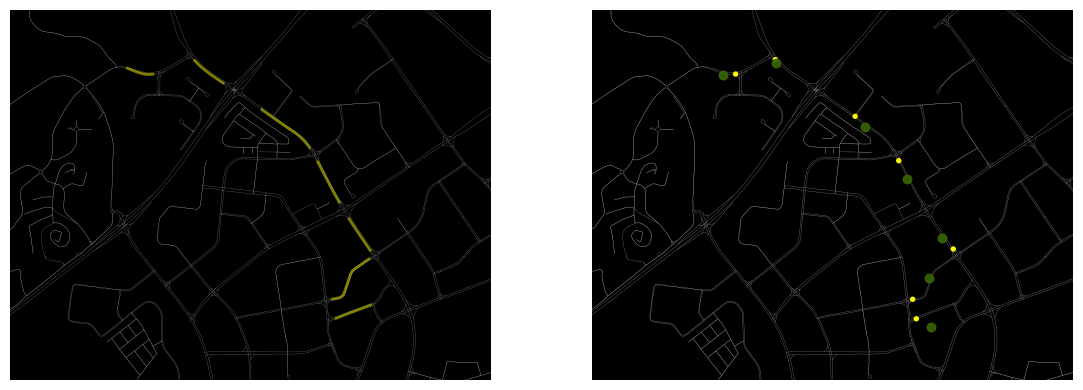

In [260]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
for ax in axes.flatten():
    ax.set_facecolor("black")
publicTransit.plot_bus_edges(G_car, gtfs, busLeg_dfs[busLeg_number], ax=axes[0], xlim_factor = 0.6,ylim_factor = 0.2)
publicTransit.plot_bus_nodes(G_car, gtfs, busLeg_dfs[busLeg_number],ax=axes[1],xlim_factor = 0.6,ylim_factor = 0.2)
plt.tight_layout()
plt.show()

# edges = get_bus_edges(G_car,busLeg_dfs[0],GTFS_shapes,plot=True)

### Get shortest path bus routes

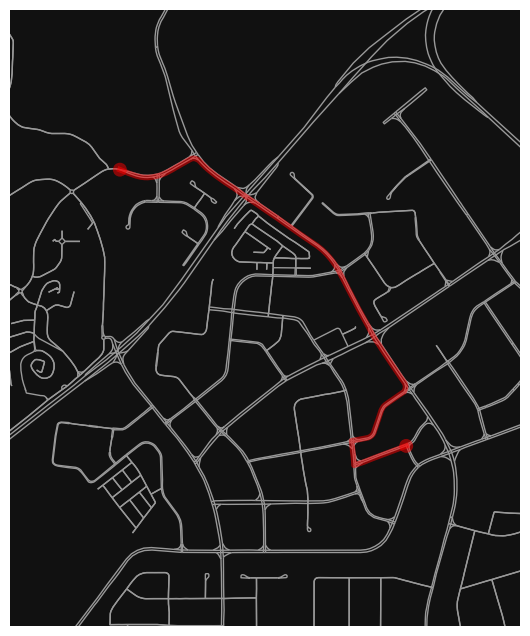

[246155560,
 2577843629,
 2577843618,
 246158694,
 2577843619,
 4745624418,
 246155892,
 2577843711,
 2577843712,
 2577843714,
 4745340939,
 2577843801,
 2577843843,
 244137878,
 244137918,
 2577843871,
 2618496604,
 889499177,
 2577843939,
 2618497983,
 6151629170,
 5159426232,
 4738356421,
 1301909257,
 4738356423,
 567938823,
 1304329326,
 1304329329,
 4604229203,
 1989607716,
 1989535699,
 4604229209,
 246168216]

In [265]:
BSR = publicTransit.BusStopRoutes(G=G_car,gtfs=gtfs)
BSR.busRoute_shortestPath(plot=True)

In [117]:
print(response['plan']['itineraries'][0]['legs'][1]['from']['arrival'])
print(response['plan']['itineraries'][0]['legs'][1]['from']['departure'])
print(response['plan']['itineraries'][0]['legs'][1]['startTime'])
print(response['plan']['itineraries'][0]['legs'][1]['endTime'])
print(response['plan']['itineraries'][0]['legs'][1]['duration'])
response['plan']['itineraries'][0]['legs'][1]

1736725208000
1736725208000
1736725208000
1736725543000
335


{'startTime': 1736725208000,
 'endTime': 1736725543000,
 'departureDelay': 0,
 'arrivalDelay': 0,
 'realTime': False,
 'distance': 1798.29,
 'generalizedCost': 935,
 'pathway': False,
 'mode': 'BUS',
 'transitLeg': True,
 'route': '139',
 'agencyName': 'SBS Transit',
 'agencyUrl': 'http://www.sbstransit.com.sg/',
 'agencyTimeZoneOffset': 28800000,
 'routeType': 3,
 'routeId': '139',
 'interlineWithPreviousLeg': False,
 'agencyId': '1:SBST',
 'tripId': '139-2-1003',
 'serviceDate': '2025-01-13',
 'from': {'name': "CURTIN S'PORE",
  'stopId': 'FERRY:52419',
  'stopCode': '52419',
  'lon': 103.8539175,
  'lat': 1.3280331,
  'arrival': 1736725208000,
  'departure': 1736725208000,
  'stopIndex': 34,
  'stopSequence': 35,
  'vertexType': 'TRANSIT'},
 'to': {'name': 'OPP TAN TONG MENG TWR',
  'stopId': 'FERRY:51011',
  'stopCode': '51011',
  'lon': 103.8409547,
  'lat': 1.3277045,
  'arrival': 1736725543000,
  'departure': 1736725756000,
  'stopIndex': 38,
  'stopSequence': 39,
  'vertexType'

In [53]:
from datetime import datetime
datetime.fromtimestamp(response['plan']['itineraries'][0]['startTime']/1000).strftime('%Y-%m-%d %H:%M:%S')
# stops_df['arrival'] = pd.to_datetime(stops_df['arrival'],unit='ms')
# stops_df['departure'] = pd.to_datetime(stops_df['departure'],unit='ms')

'2023-08-13 07:35:00'

In [67]:
print(response['plan']['itineraries'][0]['legs'][0]['startTime'])
print(response['plan']['itineraries'][0]['legs'][0]['endTime'])
print(response['plan']['itineraries'][0]['legs'][0]['mode'])
print(response['plan']['itineraries'][0]['legs'][0]['from'])
print(response['plan']['itineraries'][0]['legs'][0]['to'])
print(response['plan']['itineraries'][0]['legs'][0]['distance']) # distance in metres
print(response['plan']['itineraries'][0]['legs'][0]['pathway'])
print(response['plan']['itineraries'][0]['legs'][0]['duration']) # duration in seconds

1691883300000
1691885159000
WALK
{'name': 'Origin', 'lon': 103.84415, 'lat': 1.320981, 'departure': 1691883300000, 'vertexType': 'NORMAL'}
{'name': 'Destination', 'lon': 103.8559, 'lat': 1.326762, 'arrival': 1691885159000, 'vertexType': 'NORMAL'}
1971.42
False
1859


In [60]:
datetime.fromtimestamp(response['plan']['itineraries'][0]['legs'][0]['endTime']/1000) - datetime.fromtimestamp(response['plan']['itineraries'][0]['startTime']/1000)


datetime.timedelta(seconds=1859)